# **Forecasting series temporales con gradient boosting: Skforecast, XGBoost, LightGBM y CatBoost**

# **Introducción**
Los modelos gradient boosting destacan dentro de la comunidad de machine learning debido a su capacidad para lograr excelentes resultados en una amplia variedad de casos de uso, incluyendo tanto la regresión como la clasificación. Aunque su uso en el forecasting de series temporales ha sido limitado, también pueden conseguir resultados muy competitivos en este ámbito. Algunas de las ventajas que presentan los modelos gradient boosting para forecasting son:

La facilidad con que pueden incorporarse al modelo variables exógenas, además de las autorregresivas.

La capacidad de capturar relaciones no lineales entre variables.

Alta escalabilidad, que permite a los modelos manejar grandes volúmenes de datos.

Algunas implementaciones permiten la inclusión de variables categóricas sin necesidad de codificación adicional, como la codificación one-hot.

A pesar de estas ventajas, el uso de modelos de machine learning para forecasting presenta varios retos que pueden hacer que el analista sea reticente a su uso, los principales son:

Reestructurar los datos para poder utilizarlos como si se tratara de un problema de regresión.

Dependiendo de cuántas predicciones futuras se necesiten (horizonte de predicción), puede ser necesario implementar un proceso iterativo en el que cada nueva predicción se base en las anteriores.

La validación de los modelos requiere de estrategias específicas como backtesting, walk-forward validation o time series cross-validation. No puede aplicarse la validación cruzada tradicional.

La librería skforecast ofrece soluciones automatizadas a estos retos, facilitando el uso y la validación de modelos de machine learning en problemas de forecasting. Skforecast es compatible con las implementaciones de gradient boosting más avanzadas, incluyendo XGBoost, LightGBM, Catboost y HistGradientBoostingRegressor. Este documento muestra cómo utilizarlos para construir modelos de forecasting precisos.

Para garantizar una experiencia de aprendizaje fluida, se realiza una exploración inicial de los datos. A continuación, se explica paso a paso el proceso de modelización, empezando por un modelo recursivo que utiliza un regresor LightGBM y pasando por un modelo que incorpora variables exógenas y diversas estrategias de codificación. El documento concluye demostrando el uso de otras implementaciones de modelos de gradient boosting, como XGBoost, CatBoost y el HistGradientBoostingRegressor de scikit-learn.

#**✎ Nota**

Los modelos de machine learning no siempre superan a los modelos propios del aprendizaje estadístico como AR, ARIMA o Exponential Smoothing. Cuál funciona mejor depende en gran medida de las características del caso de uso al que se apliquen. Consultar Modelos ARIMA y SARIMAX con python para aprender más sobre modelos estadísticos.
#**✎ Nota**

Otro ejemplo de cómo utilizar modelos de gradient boosting para forecasting puede encontrarse en el documento Forecasting de la demanda energética con machine learning.
#**Caso de uso**
Los sistemas de bicicletas compartidas, también conocidos como sistemas de bicicletas públicas, facilitan la disponibilidad automática de bicicletas para que sean utilizadas temporalmente como medio de transporte. La mayoría de estos sistemas permiten recoger una bicicleta y devolverla en un punto diferente (estaciones o dockers), para que el usuario solo necesite tener la bicicleta en su posesión durante el desplazamiento. Uno de los principales retos en la gestión de estos sistemas es la necesidad de redistribuir las bicicletas para intentar que, en todas las estaciones, haya bicicletas disponibles a la vez que espacios libres para devoluciones.

Con el objetivo de mejorar la planificación y ejecución de la distribución de las bicicletas, se plantea crear un modelo capaz de predecir el número de usuarios para las siguientes 36 horas. De esta forma, a las 12h de cada día, la compañía encargada de gestionar las estaciones de alquiler podrá conocer la demanda prevista el resto del día (12 horas) y el siguiente día (24 horas).

A efectos ilustrativos, el ejemplo actual sólo modela una estación, sin embargo, el modelo puede ampliarse para cubrir múltiples estaciones utilizando global multi-series forecasting, mejorando así la gestión de los sistemas de bicicletas compartidas a mayor escala.

#**Librerías**
Las librerías utilizadas en este documento son:

In [ ]:
# Data processing
# ==============================================================================
# Instalación de librerías necesarias
!pip install -q astral session-info numpy pandas matplotlib plotly xgboost lightgbm catboost scikit-learn shap feature-engine skforecast
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import WindowFeatures

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
import xgboost
import lightgbm
import catboost
import sklearn
import shap
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

import skforecast
from skforecast.recursive import ForecasterEquivalentDate
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, OneStepAheadFold
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.feature_selection import select_features

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión lightgbm: {lightgbm.__version__}")
print(f"{color}Versión xgboost: {xgboost.__version__}")
print(f"{color}Versión catboost: {catboost.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.14.0
Versión scikit-learn: 1.5.2
Versión lightgbm: 4.5.0
Versión xgboost: 2.1.3
Versión catboost: 1.2.7
Versión pandas: 2.2.2
Versión numpy: 1.26.4


# **⚠ Warning**

En el momento de escribir este documento, catboost solo es compatible con numpy en versiones inferiores a 2.0. Si tienes una versión superior, puedes reducirla ejecutando el siguiente comando: pip install numpy==1.26.4
# **Datos**

In [1]:
# Descarga de datos
# ==============================================================================

import pandas as pd

# Cargar los datos desde el archivo Excel
datos = pd.read_excel('/content/datos_ingenieria.xlsx')

# Mostrar únicamente las primeras filas del DataFrame
datos.head()

fecha  temperatura      presion  velocviento   humendad  \
0  1910-01-01    17.490802  1015.791540     3.285316  48.826402   
1  1910-01-02    29.014286  1024.417858    16.291494  51.024310   
2  1910-01-03    24.639879  1023.580260    13.303944  49.321913   
3  1910-01-04    21.973170  1012.936867    10.461308  78.979224   
4  1910-01-05    13.120373  1011.040420     7.176610  57.506263   

   produc_energia  
0      454.477965  
1      686.109679  
2      195.933727  
3      692.060774  
4      999.472353

In [ ]:
# Preprocesado de datos (estableciendo índice y frecuencia)
# ==============================================================================
datos = datos[['date_time', 'users', 'holiday', 'weather', 'temp', 'atemp', 'hum', 'windspeed']]
datos['date_time'] = pd.to_datetime(datos['date_time'], format='%Y-%m-%d %H:%M:%S')
datos = datos.set_index('date_time')
if pd.__version__ < '2.2':
    datos = datos.asfreq('H')
else:
    datos = datos.asfreq('h')
datos = datos.sort_index()
datos.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



users  holiday weather  temp   atemp   hum  windspeed
date_time                                                                 
2011-01-01 00:00:00   16.0      0.0   clear  9.84  14.395  81.0        0.0
2011-01-01 01:00:00   40.0      0.0   clear  9.02  13.635  80.0        0.0
2011-01-01 02:00:00   32.0      0.0   clear  9.02  13.635  80.0        0.0
2011-01-01 03:00:00   13.0      0.0   clear  9.84  14.395  75.0        0.0
2011-01-01 04:00:00    1.0      0.0   clear  9.84  14.395  75.0        0.0

In [ ]:
# Separación de datos en entrenamiento, validación y test
# ==============================================================================
fin_train = '2012-04-30 23:59:00'
fin_validacion = '2012-08-31 23:59:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]
print(
    f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  "
    f"(n={len(datos_train)})"
)
print(
    f"Fechas validación : {datos_val.index.min()} --- {datos_val.index.max()}  "
    f"(n={len(datos_val)})"
)
print(
    f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  "
    f"(n={len(datos_test)})"
)

Fechas train      : 2011-01-01 00:00:00 --- 2012-04-30 23:00:00  (n=11664)
Fechas validación : 2012-05-01 00:00:00 --- 2012-08-31 23:00:00  (n=2952)
Fechas test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# **Exploración gráfica**
La exploración gráfica de series temporales es una forma eficaz de identificar tendencias, patrones y variaciones estacionales. Esto, a su vez, ayuda a orientar la selección del modelo de forecasting más adecuado.

## **Representación de la serie temporal**
### **Serie temporal completa**

In [ ]:
# Gráfico interactivo de la serie temporal
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=datos_train.index, y=datos_train['users'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=datos_val.index, y=datos_val['users'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=datos_test.index, y=datos_test['users'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Número de usuarios',
    xaxis_title="Fecha",
    yaxis_title="Usiarios",
    legend_title="Partición:",
    width=750,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1, xanchor="left", x=0.001)
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

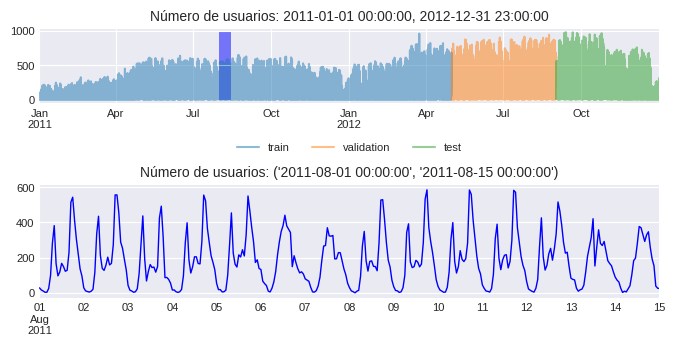

In [ ]:
# Gráfico de la serie temporal con zoom
# ==============================================================================
zoom = ('2011-08-01 00:00:00','2011-08-15 00:00:00')
fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.1, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

datos_train['users'].plot(ax=main_ax, label='train', alpha=0.5)
datos_val['users'].plot(ax=main_ax, label='validation', alpha=0.5)
datos_test['users'].plot(ax=main_ax, label='test', alpha=0.5)
min_y = min(datos['users'])
max_y = max(datos['users'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))
datos.loc[zoom[0]: zoom[1]]['users'].plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Número de usuarios: {datos.index.min()}, {datos.index.max()}', fontsize=10)
zoom_ax.set_title(f'Número de usuarios: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

# **Gráficos de estacionalidad**
Los gráficos estacionales son una herramienta útil para identificar patrones y tendencias estacionales en una serie temporal. Se crean promediando los valores de cada estación a lo largo del tiempo y luego trazándolos en función del tiempo.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



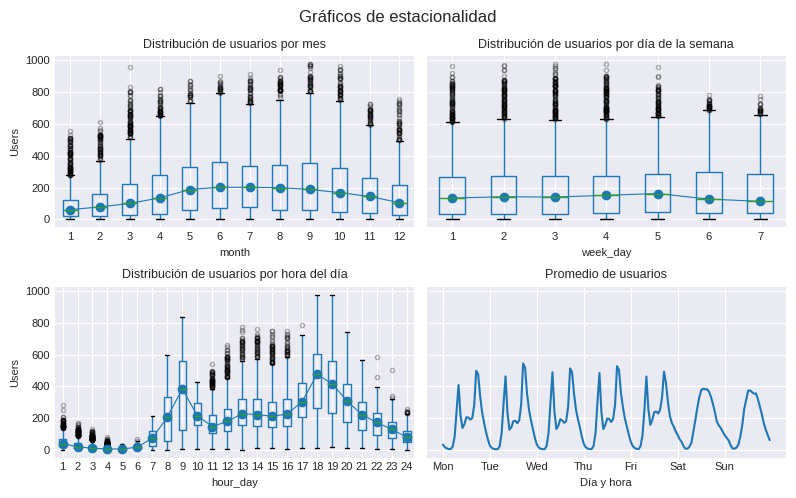

In [ ]:
# Estacionalidad anual, semanal y diaria
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=False, sharey=True)
axs = axs.ravel()

# Distribusión de usuarios por mes
datos['month'] = datos.index.month
datos.boxplot(column='users', by='month', ax=axs[0], flierprops={'markersize': 3, 'alpha': 0.3})
datos.groupby('month')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('Users')
axs[0].set_title('Distribución de usuarios por mes', fontsize=9)

# Distribusión de usuarios por día de la semana
datos['week_day'] = datos.index.day_of_week + 1
datos.boxplot(column='users', by='week_day', ax=axs[1], flierprops={'markersize': 3, 'alpha': 0.3})
datos.groupby('week_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('Users')
axs[1].set_title('Distribución de usuarios por día de la semana', fontsize=9)

# Distribusión de usuarios por hora del día
datos['hour_day'] = datos.index.hour + 1
datos.boxplot(column='users', by='hour_day', ax=axs[2], flierprops={'markersize': 3, 'alpha': 0.3})
datos.groupby('hour_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('Users')
axs[2].set_title('Distribución de usuarios por hora del día', fontsize=9)

# Distribusión de usuarios por día de la semana y hora del día
mean_day_hour = datos.groupby(["week_day", "hour_day"])["users"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Promedio de usuarios",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel      = "Día y hora",
    ylabel      = "Users"
)
axs[3].title.set_size(9)

fig.suptitle("Gráficos de estacionalidad", fontsize=12)
fig.tight_layout()


Existe una clara diferencia entre los días entre semana y el fin de semana. También se observa un claro patrón intradiario, con diferente afluencia de usuarios dependiendo de la hora del día.

# **Gráficos de autocorrelación**
Los gráficos de autocorrelación muestran la correlación entre una serie temporal y sus valores pasados. Son una herramienta útil para identificar el orden de un modelo autorregresivo, es decir, los valores pasados (lags) que se deben incluir en el modelo.

La función de autocorrelación (ACF) mide la correlación entre una serie temporal y sus valores pasados. La función de autocorrelación parcial (PACF) mide la correlación entre una serie temporal y sus valores pasados, pero solo después de eliminar las variaciones explicadas por los valores pasados intermedios.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



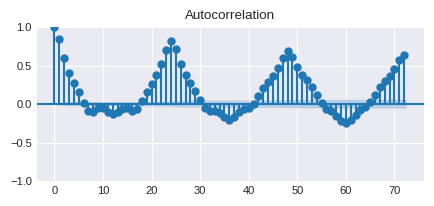

In [ ]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(datos['users'], ax=ax, lags=72)
plt.show()

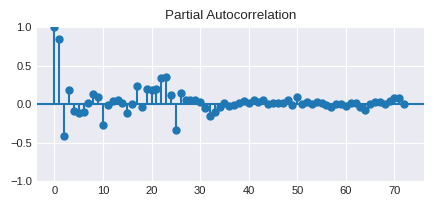

In [ ]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(datos['users'], ax=ax, lags=72, method='ywm')
plt.show()

Los resultados del estudio de autocorrelación indican una correlación significativa entre el número de usuarios en las horas anteriores, así como en los días previos. Esto significa que conocer del número de usuarios durante periodos específicos del pasado proporciona información útil para predecir el número de usuarios en el futuro.

# **Baseline**
Al enfrentarse a un problema de forecasting, es recomendable disponer de un modelo de referencia (baseline). Se trata de un modelo muy sencillo que puede utilizarse como referencia para evaluar si merece la pena aplicar modelos más complejos.

Skforecast permite crear fácilmente un modelo de referencia con su clase ForecasterEquivalentDate. Este modelo, también conocido como Seasonal Naive Forecasting, simplemente devuelve el valor observado en el mismo periodo de la temporada anterior (por ejemplo, el mismo día laboral de la semana anterior, la misma hora del día anterior, etc.).

A partir del análisis exploratorio realizado, el modelo de referencia será el que prediga cada hora utilizando el valor de la misma hora del día anterior.

# **✎ Nota**

En las siguientes celdas de código, se entrena un modelo baseline y se evalúa su capacidad predictiva mediante un proceso de backtesting. Si este concepto es nuevo para ti, no te preocupes, se explicará en detalle a lo largo del documento. Por ahora, basta con saber que el proceso de backtesting consiste en entrenar el modelo con una cierta cantidad de datos y evaluar su capacidad predictiva con los datos que el modelo no ha visto. La métrica del error se utilizará como referencia para comparar la capacidad predictiva de los modelos más complejos que se implementarán a lo largo del documento.

In [ ]:
# Crear un baseline: valor de la misma hora del día anterior
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                offset    = pd.DateOffset(days=1),
                n_offsets = 1
             )

# Entremaiento del forecaster
# ==============================================================================
forecaster.fit(y=datos.loc[:fin_validacion, 'users'])
forecaster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ForecasterEquivalentDate 
Offset: <DateOffset: days=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 24 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Creation date: 2024-12-15 14:59:29 
Last fit date: 2024-12-15 14:59:29 
Skforecast version: 0.14.0 
Python version: 3.10.12 
Forecaster id: None 

In [ ]:
# Backtesting
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 36,
        initial_train_size = len(datos.loc[:fin_validacion]),
        refit              = False,
)
metrica_baseline, predicciones = backtesting_forecaster(
                                    forecaster    = forecaster,
                                    y             = datos['users'],
                                    cv            = cv,
                                    metric        = 'mean_absolute_error',
                                    n_jobs        = 'auto',
                                    verbose       = False,
                                    show_progress = True
                                )
metrica_baseline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/82 [00:00<?, ?it/s]

mean_absolute_error
0            91.668716

El MAE del modelo baseline se utiliza como referencia para evaluar si merece la pena aplicar los modelos más complejos.

# **Modelo autoregresivo recursivo con LightGBM**
LightGBM es una implementación altamente eficiente del algoritmo gradient boosting, que se ha convertido en un referente en el campo del machine learning. La librería LightGBM incluye su propia API, así como la API de scikit-learn, lo que la hace compatible con skforecast.

En primer lugar, se entrena un modelo ForecasterAutoreg utilizando valores pasados de la variable de respuesta (lags) y la media movil como predictores. Posteriormente, se añaden variables exógenas al modelo y se evalúa la mejora de su rendimiento. Dado que los modelos de Gradient Boosting tienen un gran número de hiperparámetros, se realiza una Búsqueda Bayesiana utilizando la función bayesian_search_forecaster() para encontrar la mejor combinación de hiperparámetros y lags. Por último, se evalúa la capacidad predictiva del modelo mediante un proceso de backtesting.

# **Forecaster**

In [ ]:
# Crear el forecaster
# ==============================================================================
window_features = RollingFeatures(stats=["mean"], window_sizes=24 * 3)
forecaster = ForecasterRecursive(
                regressor       = LGBMRegressor(random_state=15926, verbose=-1),
                lags            = 24,
                window_features = window_features
             )

# Entrenar el forecaster
# ==============================================================================
forecaster.fit(y=datos.loc[:fin_validacion, 'users'])
forecaster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_72'] 
Window size: 72 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample':
    1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-12-15 14:59:31 
Last fit date: 2024-12-15 14:59:33 
Skforecast version: 0.14.0 
Python version: 3.10.12 
Forecaster id: None

In [ ]:
# Predicciones
# ==============================================================================
forecaster.predict(steps=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



2012-09-01 00:00:00    108.331027
2012-09-01 01:00:00     68.562982
2012-09-01 02:00:00     33.499525
2012-09-01 03:00:00     10.027583
2012-09-01 04:00:00      3.037563
2012-09-01 05:00:00     17.162543
2012-09-01 06:00:00     51.059825
2012-09-01 07:00:00    146.940053
2012-09-01 08:00:00    344.320596
2012-09-01 09:00:00    439.738683
Freq: h, Name: pred, dtype: float64

# **Backtesting**
Para obtener una estimación robusta de la capacidad predictiva del modelo, se realiza un proceso de backtesting. El proceso de backtesting consiste en generar una predicción para cada observación del conjunto de test, siguiendo el mismo procedimiento que se seguiría si el modelo estuviese en producción, y finalmente comparar el valor predicho con el valor real.

In [ ]:
# Backtest del modelo con lo datos de test
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 36,
        initial_train_size = len(datos.loc[:fin_validacion]),
        refit              = False,
     )
metrica, predicciones = backtesting_forecaster(
                            forecaster    = forecaster,
                            y             = datos['users'],
                            cv            = cv,
                            metric        = 'mean_absolute_error',
                            n_jobs        = 'auto',
                            verbose       = False,  # Cambiar a True para mostrar más información
                            show_progress = True
                        )
predicciones.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/82 [00:00<?, ?it/s]

pred
2012-09-01 00:00:00  108.331027
2012-09-01 01:00:00   68.562982
2012-09-01 02:00:00   33.499525
2012-09-01 03:00:00   10.027583
2012-09-01 04:00:00    3.037563

In [ ]:
# Error de backtest
# ==============================================================================
metrica

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



mean_absolute_error
0            76.464247

El error de predicción del modelo autorregresivo alcanza un MAE inferior al del modelo de referencia.

# **Optimización de hiperparámetros (tuning)**
El ForecasterRecursive entrenado utiliza los primeros 24 lags y un modelo LGMBRegressor con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados. Para encontrar los mejores hiperparámetros, se realiza una Búsqueda Bayesiana con la función bayesian_search_forecaster(). La búsqueda se lleva a cabo utilizando el mismo proceso de backtesting que antes, pero cada vez, el modelo se entrena con diferentes combinaciones de hiperparámetros y lags. Es importante señalar que la búsqueda de hiperparámetros debe realizarse utilizando el conjunto de validación, nunca con los datos de test.

La búsqueda se realiza probando cada combinación de hiperparámetros y retardos del siguiente modo:

Entrenar el modelo utilizando sólo el conjunto de entrenamiento.

El modelo se evalúa utilizando el conjunto de validación mediante backtesting.

Seleccionar la combinación de hiperparámetros y retardos que proporcione el menor error.

Volver a entrenar el modelo con la mejor combinación encontrada, esta vez utilizando tanto los datos de entrenamiento como los de validación.

Siguiendo estos pasos, se puede obtener un modelo con hiperparámetros optimizados y evitar el sobreajuste.

#**✎ Nota**

El proceso de búsqueda de hiperparámetros puede requerir una cantidad notable de tiempo, sobre todo si se utiliza una estrategia de validación basada en backtesting (TimeSeriesFold). Una alternativa más rápida consiste en utilizar una estrategia de validación basada en predicciones one-step-ahead (OneStepAheadFold). Esta estrategia es más rápida pero puede no ser tan precisa como la validación basada en backtesting. Para obtener una descripción más detallada de los pros y los contras de cada estrategia, consulte la sección [backtesting vs one-step-ahead](https://skforecast.org/latest/faq/parameters-search-backetesting-vs-one-step-ahead.html).

In [ ]:
# Búsqueda de hiperparámetros
# ==============================================================================
# Lags candidatos
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

# Espacio de búsqueda de hiperparámetros
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

# Particiones de entrenamiento y validación
cv = TimeSeriesFold(
            steps              = 36,
            initial_train_size = len(datos_train),
            refit              = False,
            fixed_train_size   = False,
     )

resultados_busqueda, frozen_trial = bayesian_search_forecaster(
    forecaster    = forecaster,
    y             = datos.loc[:fin_validacion, 'users'], # Datos test no incluidos
    cv            = cv,
    search_space  = search_space,
    metric        = 'mean_absolute_error',
    n_trials      = 20, # Aumentar para una búsqueda más exhaustiva
    random_state  = 123,
    return_best   = True,
    n_jobs        = 'auto',
    verbose       = False,
    show_progress = True
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 400, 'max_depth': 3, 'min_data_in_leaf': 236, 'learning_rate': 0.10101592561754803, 'feature_fraction': 0.6, 'max_bin': 225, 'reg_alpha': 0.4, 'reg_lambda': 0.0}
  Backtesting metric: 64.19204873851321


In [ ]:
# Resultados de la búsqueda
# ==============================================================================
resultados_busqueda.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags  \
0  [1, 2, 3, 23, 24, 25, 167, 168, 169]   
1  [1, 2, 3, 23, 24, 25, 167, 168, 169]   
2  [1, 2, 3, 23, 24, 25, 167, 168, 169]   

                                              params  mean_absolute_error  \
0  {'n_estimators': 400, 'max_depth': 3, 'min_dat...            64.192049   
1  {'n_estimators': 400, 'max_depth': 3, 'min_dat...            64.498000   
2  {'n_estimators': 400, 'max_depth': 3, 'min_dat...            65.844639   

   n_estimators  max_depth  min_data_in_leaf  learning_rate  feature_fraction  \
0         400.0        3.0             236.0       0.101016               0.6   
1         400.0        3.0             222.0       0.083926               1.0   
2         400.0        3.0             261.0       0.100016               0.6   

   max_bin  reg_alpha  reg_lambda  
0    225.0        0.4         0.0  
1    250.0        0.4         0.0  
2    200.0        0.8         0.0

In [ ]:
# Mejor modelo
# ==============================================================================
forecaster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [  1   2   3  23  24  25 167 168 169] 
Window features: ['roll_mean_72'] 
Window size: 169 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.10101592561754803,
    'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001,
    'min_split_gain': 0.0, 'n_estimators': 400, 'n_jobs': None, 'num_leaves':
    31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.4,
    'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000,
    'subsample_freq': 0, 'verbose': -1, 'min_data_in_leaf': 236,
    'feature_fraction': 0.6, 'max_bin': 225} 
fit_kwargs: {} 
Creation date: 2024-12-15 14:59:31 
Last fit date: 2024-12-15 15:01:16 
Skforecast version: 0.14.0 
Python version: 3.10.12 
Forecaster id: None

# **Backtesting con datos de test**
Una vez identificada la mejor combinación de hiperparámetros utilizando los datos de validación, se evalúa la capacidad predictiva del modelo cuando se aplica al conjunto de test. Se recomienda revisar la documentación de la función backtesting_forecaster para comprender mejor sus capacidades. Esto ayudará a utilizar todo su potencial para analizar la capacidad predictiva del modelo.

In [ ]:
# Backtest modelo final con datos de test
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 36,
        initial_train_size = len(datos.loc[:fin_validacion]),
        refit              = False,
     )
metrica, predicciones = backtesting_forecaster(
                            forecaster    = forecaster,
                            y             = datos['users'],
                            cv            = cv,
                            metric        = 'mean_absolute_error',
                            n_jobs        = 'auto',
                            verbose       = False,
                            show_progress = True
                        )
display(metrica)
predicciones.head()

  0%|          | 0/82 [00:00<?, ?it/s]

mean_absolute_error
0            64.873704

pred
2012-09-01 00:00:00  115.505608
2012-09-01 01:00:00   91.534104
2012-09-01 02:00:00   60.349164
2012-09-01 03:00:00   29.668854
2012-09-01 04:00:00   10.544213

In [ ]:
# Gráfico predicciones vs valor real
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=datos_test.index, y=datos_test['users'], name="test", mode="lines")
trace2 = go.Scatter(x=predicciones.index, y=predicciones['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicción vs valor real en test",
    xaxis_title="Fecha",
    yaxis_title="Usiarios",
    width=750,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
)
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Tras optimizar los lags y los hiperparámetros, el error de predicción del modelo autorregresivo alcanza un MAE significativamente inferior al del modelo de referencia. A continuación, se evalúa la capacidad predictiva del modelo cuando se añaden variables exógenas.

# **Variables exógenas**
Hasta ahora, sólo se han utilizado como predictores los valores pasados (lags) de la serie temporal. Sin embargo, es posible incluir otras variables como predictores. Estas variables se conocen como variables exógenas (features) y su uso puede mejorar la capacidad predictiva del modelo. Un punto muy importante que hay que tener en cuenta es que los valores de las variables exógenas deben conocerse en el momento de la predicción.

Ejemplos habituales de variables exógenas son aquellas obtenidas del calendario, como el día de la semana, el mes, el año o los días festivos. Las variables meteorológicas como la temperatura, la humedad y el viento también entran en esta categoría, al igual que las variables económicas como la inflación y los tipos de interés.

#**⚠ Warning**

Las variables exógenas deben conocerse en el momento de la predicción. Por ejemplo, si se utiliza la temperatura como variable exógena, el valor de la temperatura para la hora siguiente debe conocerse en el momento de la previsión. Si no se conoce el valor de la temperatura, la predicción no será posible.

Las variables meteorológicas deben utilizarse con precaución. Cuando el modelo se pone en producción, las condiciones meteorológicas futuras no se conocen, sino que son predicciones realizadas por los servicios meteorológicos. Al tratarse de predicciones, introducen errores en el modelo de previsión. Como consecuencia, es probable que las predicciones del modelo empeoren. Una forma de anticiparse a este problema, y conocer (no evitar) el rendimiento esperado del modelo, es utilizar las previsiones meteorológicas disponibles en el momento en que se entrena el modelo, en lugar de las condiciones reales registradas.
#**Variables de calendario y meteorológicas**
A continuación, se crean variables exógenas basadas en información del calendario, las horas de salida y puesta del sol, la temperatura y los días festivos. Estas nuevas variables se añaden a los conjuntos de entrenamiento, validación y test, y se utilizan como predictores en el modelo autorregresivo.

In [ ]:
# Variables basadas en el calendario
# ==============================================================================
features_to_extract = [
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables='index',
    features_to_extract=features_to_extract,
    drop_original=True,
)
variables_calendario = calendar_transformer.fit_transform(datos)[features_to_extract]

# Variables basadas en la luz solar
# ==============================================================================
location = LocationInfo(
    name      = 'Washington DC',
    region    = 'USA',
    timezone  = 'US/Eastern',
    latitude  = 40.516666666666666,
    longitude = -77.03333333333333
)
sunrise_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunrise'].hour
    for date in datos.index
]
sunset_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunset'].hour
    for date in datos.index
]
variables_solares = pd.DataFrame({
                        'sunrise_hour': sunrise_hour,
                        'sunset_hour': sunset_hour},
                        index = datos.index
                    )
variables_solares['daylight_hours'] = (
    variables_solares['sunset_hour'] - variables_solares['sunrise_hour']
)
variables_solares["is_daylight"] = np.where(
    (datos.index.hour >= variables_solares["sunrise_hour"])
    & (datos.index.hour < variables_solares["sunset_hour"]),
    1,
    0,
)

# Variables basadas en festivos
# ==============================================================================
variables_festivos = datos[['holiday']].astype(int)
variables_festivos['holiday_previous_day'] = variables_festivos['holiday'].shift(24)
variables_festivos['holiday_next_day'] = variables_festivos['holiday'].shift(-24)

# Variables basadas en temperatura
# ==============================================================================
wf_transformer = WindowFeatures(
    variables = ["temp"],
    window    = ["1D", "7D"],
    functions = ["mean", "max", "min"],
    freq      = "h",
)
variables_temp = wf_transformer.fit_transform(datos[['temp']])

# Unión de variables exógenas
# ==============================================================================
assert all(variables_calendario.index == variables_solares.index)
assert all(variables_calendario.index == variables_festivos.index)
assert all(variables_calendario.index == variables_temp.index)
variables_exogenas = pd.concat([
    variables_calendario,
    variables_solares,
    variables_temp,
    variables_festivos
], axis=1)

# Debido a la creación de medias móviles, hay valores faltantes al principio
# de la serie. Y debido a holiday_next_day hay valores faltantes al final.
variables_exogenas = variables_exogenas.iloc[7 * 24:, :]
variables_exogenas = variables_exogenas.iloc[:-24, :]
variables_exogenas.head(3)

month  week  day_of_week  hour  sunrise_hour  \
date_time                                                           
2011-01-08 00:00:00      1     1            5     0             7   
2011-01-08 01:00:00      1     1            5     1             7   
2011-01-08 02:00:00      1     1            5     2             7   

                     sunset_hour  daylight_hours  is_daylight  temp  \
date_time                                                             
2011-01-08 00:00:00           16               9            0  7.38   
2011-01-08 01:00:00           16               9            0  7.38   
2011-01-08 02:00:00           16               9            0  7.38   

                     temp_window_1D_mean  temp_window_1D_max  \
date_time                                                      
2011-01-08 00:00:00             8.063333                9.02   
2011-01-08 01:00:00             8.029167                9.02   
2011-01-08 02:00:00             7.995000                9.02   

                     temp_window_1D_min  temp_window_7D_mean  \
date_time                                                      
2011-01-08 00:00:00                6.56            10.127976   
2011-01-08 01:00:00                6.56            10.113333   
2011-01-08 02:00:00                6.56            10.103571   

                     temp_window_7D_max  temp_window_7D_min  holiday  \
date_time                                                              
2011-01-08 00:00:00               18.86                4.92        0   
2011-01-08 01:00:00               18.86                4.92        0   
2011-01-08 02:00:00               18.86                4.92        0   

                     holiday_previous_day  holiday_next_day  
date_time                                                    
2011-01-08 00:00:00                   0.0               0.0  
2011-01-08 01:00:00                   0.0               0.0  
2011-01-08 02:00:00                   0.0               0.0

# **Variables con patrones cíclicos**
Algunos aspectos del calendario, como las horas o los días, son cíclicos. Por ejemplo, la hora del día va de 0 a 23 horas. Este tipo de variables pueden tratarse de varias formas, cada una con sus ventajas e inconvenientes.

Un enfoque consiste en utilizar las variables directamente como valores numéricos sin ninguna transformación. Este método evita crear variables nuevas, pero puede imponer un orden lineal incorrecto a los valores. Por ejemplo, la hora 23 de un día y la hora 00 del siguiente están muy alejadas en su representación lineal, cuando en realidad sólo hay una hora de diferencia entre ellas.

Otra posibilidad es tratar las variables cíclicas como variables categóricas para evitar imponer un orden lineal. Sin embargo, este enfoque puede provocar la pérdida de la información cíclica inherente a la variable.

Existe una tercera forma de tratar las variables cíclicas que suele preferirse a los otros dos métodos. Se trata de transformar las variables utilizando el seno y el coseno de su periodo. Este método genera solo dos nuevas variables que captan la ciclicidad de los datos con mayor precisión que los dos métodos anteriores, ya que preserva el orden natural de la variable y evita imponer un orden lineal.

# **✎ Nota**

Para información más detallada sobre las diferentes formas de tratar las variables cíclicas, consultar el documento Cyclical features in time series forecasting.

In [ ]:
# Codificación cíclica de las variables de calendario y luz solar
# ==============================================================================
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
    "sunrise_hour",
    "sunset_hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 6,
    "hour": 23,
    "sunrise_hour": 23,
    "sunset_hour": 23,
}
cyclical_encoder = CyclicalFeatures(
    variables     = features_to_encode,
    max_values    = max_values,
    drop_original = False
)

variables_exogenas = cyclical_encoder.fit_transform(variables_exogenas)
variables_exogenas.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



month  week  day_of_week  hour  sunrise_hour  \
date_time                                                           
2011-01-08 00:00:00      1     1            5     0             7   
2011-01-08 01:00:00      1     1            5     1             7   
2011-01-08 02:00:00      1     1            5     2             7   

                     sunset_hour  daylight_hours  is_daylight  temp  \
date_time                                                             
2011-01-08 00:00:00           16               9            0  7.38   
2011-01-08 01:00:00           16               9            0  7.38   
2011-01-08 02:00:00           16               9            0  7.38   

                     temp_window_1D_mean  ...  week_sin  week_cos  \
date_time                                 ...                       
2011-01-08 00:00:00             8.063333  ...  0.120537  0.992709   
2011-01-08 01:00:00             8.029167  ...  0.120537  0.992709   
2011-01-08 02:00:00             7.995000  ...  0.120537  0.992709   

                     day_of_week_sin  day_of_week_cos  hour_sin  hour_cos  \
date_time                                                                   
2011-01-08 00:00:00        -0.866025              0.5  0.000000  1.000000   
2011-01-08 01:00:00        -0.866025              0.5  0.269797  0.962917   
2011-01-08 02:00:00        -0.866025              0.5  0.519584  0.854419   

                     sunrise_hour_sin  sunrise_hour_cos  sunset_hour_sin  \
date_time                                                                  
2011-01-08 00:00:00          0.942261          -0.33488        -0.942261   
2011-01-08 01:00:00          0.942261          -0.33488        -0.942261   
2011-01-08 02:00:00          0.942261          -0.33488        -0.942261   

                     sunset_hour_cos  
date_time                             
2011-01-08 00:00:00         -0.33488  
2011-01-08 01:00:00         -0.33488  
2011-01-08 02:00:00         -0.33488  

[3 rows x 30 columns]

# **Interacción entre variables**
En muchos casos, las variables exógenas no son independientes. Más bien, su efecto sobre la variable objetivo depende del valor de otras variables. Por ejemplo, el efecto de la temperatura en la demanda de electricidad depende de la hora del día. La interacción entre las variables exógenas puede captarse mediante nuevas variables que se obtienen multiplicando entre sí las variables existentes. Estas interacciones se obtienen fácilmente con la clase PolynomialFeatures de scikit-learn.

In [ ]:
# Interacción entre variables exógenas
# ==============================================================================
transformer_poly = PolynomialFeatures(
                        degree           = 2,
                        interaction_only = True,
                        include_bias     = False
                    ).set_output(transform="pandas")
poly_cols = [
    'month_sin',
    'month_cos',
    'week_sin',
    'week_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'hour_sin',
    'hour_cos',
    'sunrise_hour_sin',
    'sunrise_hour_cos',
    'sunset_hour_sin',
    'sunset_hour_cos',
    'daylight_hours',
    'is_daylight',
    'holiday_previous_day',
    'holiday_next_day',
    'temp_window_1D_mean',
    'temp_window_1D_min',
    'temp_window_1D_max',
    'temp_window_7D_mean',
    'temp_window_7D_min',
    'temp_window_7D_max',
    'temp',
    'holiday'
]
variables_poly = transformer_poly.fit_transform(variables_exogenas[poly_cols])
variables_poly = variables_poly.drop(columns=poly_cols)
variables_poly.columns = [f"poly_{col}" for col in variables_poly.columns]
variables_poly.columns = variables_poly.columns.str.replace(" ", "__")
assert all(variables_exogenas.index == variables_poly.index)
variables_exogenas = pd.concat([variables_exogenas, variables_poly], axis=1)
variables_exogenas.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



month  week  day_of_week  hour  sunrise_hour  \
date_time                                                           
2011-01-08 00:00:00      1     1            5     0             7   
2011-01-08 01:00:00      1     1            5     1             7   
2011-01-08 02:00:00      1     1            5     2             7   

                     sunset_hour  daylight_hours  is_daylight  temp  \
date_time                                                             
2011-01-08 00:00:00           16               9            0  7.38   
2011-01-08 01:00:00           16               9            0  7.38   
2011-01-08 02:00:00           16               9            0  7.38   

                     temp_window_1D_mean  ...  \
date_time                                 ...   
2011-01-08 00:00:00             8.063333  ...   
2011-01-08 01:00:00             8.029167  ...   
2011-01-08 02:00:00             7.995000  ...   

                     poly_temp_window_7D_mean__temp_window_7D_min  \
date_time                                                           
2011-01-08 00:00:00                                     49.829643   
2011-01-08 01:00:00                                     49.757600   
2011-01-08 02:00:00                                     49.709571   

                     poly_temp_window_7D_mean__temp_window_7D_max  \
date_time                                                           
2011-01-08 00:00:00                                    191.013631   
2011-01-08 01:00:00                                    190.737467   
2011-01-08 02:00:00                                    190.553357   

                     poly_temp_window_7D_mean__temp  \
date_time                                             
2011-01-08 00:00:00                       74.744464   
2011-01-08 01:00:00                       74.636400   
2011-01-08 02:00:00                       74.564357   

                     poly_temp_window_7D_mean__holiday  \
date_time                                                
2011-01-08 00:00:00                                0.0   
2011-01-08 01:00:00                                0.0   
2011-01-08 02:00:00                                0.0   

                     poly_temp_window_7D_min__temp_window_7D_max  \
date_time                                                          
2011-01-08 00:00:00                                      92.7912   
2011-01-08 01:00:00                                      92.7912   
2011-01-08 02:00:00                                      92.7912   

                     poly_temp_window_7D_min__temp  \
date_time                                            
2011-01-08 00:00:00                        36.3096   
2011-01-08 01:00:00                        36.3096   
2011-01-08 02:00:00                        36.3096   

                     poly_temp_window_7D_min__holiday  \
date_time                                               
2011-01-08 00:00:00                               0.0   
2011-01-08 01:00:00                               0.0   
2011-01-08 02:00:00                               0.0   

                     poly_temp_window_7D_max__temp  \
date_time                                            
2011-01-08 00:00:00                       139.1868   
2011-01-08 01:00:00                       139.1868   
2011-01-08 02:00:00                       139.1868   

                     poly_temp_window_7D_max__holiday  poly_temp__holiday  
date_time                                                                  
2011-01-08 00:00:00                               0.0                 0.0  
2011-01-08 01:00:00                               0.0                 0.0  
2011-01-08 02:00:00                               0.0                 0.0  

[3 rows x 306 columns]

# **Variables categóricas**
Existen varios enfoques para incorporar variables categóricas en LightGBM (y otras implementaciones de gradient boosting):

Una opción es transformar los datos convirtiendo los valores categóricos en valores numéricos utilizando métodos como la codificación one hot la codificación ordinal. Este enfoque es aplicable a todos los modelos de aprendizaje automático.

LightGBM puede manejar variables categóricas internamente sin necesidad de preprocesamiento. Esto puede hacerse automáticamente estableciendo el parámetro categorical_features='auto' y almacenando las variables con el tipo de dato category dentro de un Pandas DataFrame. Tambien es posible especificar los nombres de las variables a tratar como categóricas pasando una lista de nombres al parámetro categorical_features.

No hay un método que sea siempre mejor que los otros. Las reglas generales son:

Cuando la cardinalidad de las variables categóricas es alta (muchos valores diferentes), es mejor utilizar el soporte nativo para variables categóricas que utilizar la codificación one-hot.

Con datos codificados con one hot encoding, se necesitan más puntos de división (es decir, más profundidad) para recuperar una división equivalente a la que podría obtenerse con un solo punto de división utilizando el tratamiento nativo.

Cuando una variable categórica se convierte en múltiples variables dummy utilizando one hot encoding, su importancia se diluye, haciendo que el análisis de la importancia de las características sea más complejo de interpretar.

In [ ]:
# Almacenar las variables categoricas como tipo "category"
# ==============================================================================
datos["weather"] = datos["weather"].astype("category")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# **One hot encoding**
ColumnTransformers en scikit-learn proporcionan una potente forma de definir transformaciones y aplicarlas a variables específicas. Al encapsular las transformaciones en un objeto ColumnTransformer, se puede pasar a un Forecaster utilizando el argumento transformer_exog.

# **✎ Nota**

Es posible aplicar una transformación a todo el conjunto de datos independientemente del forecaster. Sin embargo, es crucial asegurarse de que las transformaciones se aprenden sólo a partir de los datos de entrenamiento para evitar fugas de información (*leakage*). Además, la misma transformación debe aplicarse a los datos de entrada durante la predicción. Por lo tanto, es aconsejable incluir la transformación en el forecaster para que se gestione internamente. Este enfoque garantiza la coherencia en la aplicación de las transformaciones y reduce la probabilidad de errores.

In [ ]:
# Transformación con codificación one-hot
# ==============================================================================
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='if_binary'),
        make_column_selector(dtype_include=['category', 'object']),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")
# Crear un forecaster con un transformer para las variables exógenas
# ==============================================================================
forecaster = ForecasterRecursive(
                regressor        = LGBMRegressor(random_state=15926, verbose=-1),
                lags             = 72,
                transformer_exog = one_hot_encoder
             )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Mostrar matrices de entrenamiento
# ==============================================================================
exog_cols = ['weather']
X_train, y_train = forecaster.create_train_X_y(
                        y    = datos.loc[:fin_validacion, 'users'],
                        exog = datos.loc[:fin_validacion, exog_cols]
                   )
X_train.head(3)

lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  \
date_time                                                                     
2011-01-04 00:00:00   12.0   20.0   52.0   52.0  110.0  157.0  157.0   76.0   
2011-01-04 01:00:00    5.0   12.0   20.0   52.0   52.0  110.0  157.0  157.0   
2011-01-04 02:00:00    2.0    5.0   12.0   20.0   52.0   52.0  110.0  157.0   

                     lag_9  lag_10  ...  lag_66  lag_67  lag_68  lag_69  \
date_time                           ...                                   
2011-01-04 00:00:00   72.0    77.0  ...     2.0     1.0     1.0    13.0   
2011-01-04 01:00:00   76.0    72.0  ...     3.0     2.0     1.0     1.0   
2011-01-04 02:00:00  157.0    76.0  ...     8.0     3.0     2.0     1.0   

                     lag_70  lag_71  lag_72  weather_clear  weather_mist  \
date_time                                                                  
2011-01-04 00:00:00    32.0    40.0    16.0            1.0           0.0   
2011-01-04 01:00:00    13.0    32.0    40.0            1.0           0.0   
2011-01-04 02:00:00     1.0    13.0    32.0            1.0           0.0   

                     weather_rain  
date_time                          
2011-01-04 00:00:00           0.0  
2011-01-04 01:00:00           0.0  
2011-01-04 02:00:00           0.0  

[3 rows x 75 columns]

# **Implementación nativa para variables categóricas**
Las librerías de Gradient Boosting (XGBoost, LightGBM, CatBoost y HistGradientBoostingRegressor) asumen que las variables de entrada son números enteros empezando por 0 hasta el número de categorías [0, 1, ..., n_categories-1]. En la mayoría de los casos reales, las variables categóricas no se codifican con números sino con cadenas (strings), por lo que es necesario un paso intermedio de transformación. Existen dos opciones:

Asignar a las columnas con variables categóricas el tipo category. Internamente, esta estructura de datos consiste en una matriz de categorías y una matriz de valores enteros (códigos) que apuntan al valor real de la matriz de categorías. Es decir, internamente es una matriz numérica con un mapeo que relaciona cada valor con una categoría. Los modelos son capaces de identificar automáticamente las columnas de tipo category y acceder a sus códigos internos. Este enfoque es aplicable a XGBoost, LightGBM y CatBoost.

Preprocesar las columnas categóricas con un OrdinalEncoder para transformar sus valores a enteros y luego indicar explícitamente que deben ser tratadas como categóricas.

Para utilizar la detección automática en skforecast, las variables categóricas deben codificarse primero como enteros y luego almacenarse de nuevo como tipo category. Esto se debe a que skforecast utiliza internamente una matriz numérica numpy para acelerar el cálculo.

# **⚠ Warning**

Los cuatro librerías de gradient boosting - LightGBM, HistogramGradientBoosting de scikit-learn, XGBoost y CatBoost - son capaces de manejar directamente características categóricas dentro del modelo. Sin embargo, es importante señalar que cada una tiene sus propias configuraciones, ventajas y potenciales problemas. Para comprender plenamente cómo utilizar cada una, se recomienda consultar esta guía de usuario.

Cuando se desplegan modelos en producción, se recomienda evitar la detección automática basada en columnas de tipo category de pandas. Aunque pandas proporciona una codificación interna para estas columnas, no es consistente entre diferentes conjuntos de datos y puede variar dependiendo de las categorías presentes en cada conjunto de datos. Por lo tanto, es crucial ser consciente de este problema y tomar las medidas adecuadas para garantizar la consistencia en la codificación de las variables categóricas al desplegar modelos en producción. Se puede encontrar más información sobre este problema en Native implementation for categorical features.

In [ ]:
# Transformación: codificación ordinal + conversión a tipo "category"
# ==============================================================================
pipeline_categorical = make_pipeline(
    OrdinalEncoder(
        dtype=int,
        handle_unknown="use_encoded_value",
        unknown_value=-1,
        encoded_missing_value=-1
    ),
    FunctionTransformer(
        func=lambda x: x.astype('category'),
        feature_names_out= 'one-to-one'
    )
)

transformer_exog = make_column_transformer(
    (
        pipeline_categorical,
        make_column_selector(dtype_include=['category', 'object']),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Crear un forecaster con detección automática de variables categóricas (LGBMRegressor)
# ==============================================================================
forecaster = ForecasterRecursive(
                regressor        = LGBMRegressor(random_state=15926, verbose=-1),
                lags             = 72,
                transformer_exog = transformer_exog,
                fit_kwargs       = {"categorical_feature": "auto"}
             )

Esta es la estrategia que se utilizará en el resto del documento.

# **Evaluar el modelo con variables exógenas**
Se entrena de nuevo el forecaster, pero esta vez, las variables exógenas también se incluyen como predictores. Para las variables categóricas, se utiliza la implementación nativa.

In [ ]:
# Selección de variables exógenas a incluir en el modelo
# ==============================================================================
exog_cols = []
# Columnas que terminan con _seno o _coseno son seleccionadas
exog_cols.extend(variables_exogenas.filter(regex='_sin$|_cos$').columns.tolist())
# Columnas que empiezan con tem_ son seleccionadas
exog_cols.extend(variables_exogenas.filter(regex='^temp_.*').columns.tolist())
# Columnas que empiezan con holiday_ son seleccionadas
exog_cols.extend(variables_exogenas.filter(regex='^holiday_.*').columns.tolist())
exog_cols.extend(['temp', 'holiday', 'weather'])

variables_exogenas = variables_exogenas.filter(exog_cols, axis=1)

In [ ]:
# Combinar variables exógenas y target en el mismo dataframe
# ==============================================================================
datos = datos[['users', 'weather']].merge(
            variables_exogenas,
            left_index=True,
            right_index=True,
            how='inner' # Para utilizar solo fechas para las que hay datos exógenos
        )
datos = datos.astype({col: np.float32 for col in datos.select_dtypes("number").columns})
datos_train = datos.loc[: fin_train, :].copy()
datos_val   = datos.loc[fin_train:fin_validacion, :].copy()
datos_test  = datos.loc[fin_validacion:, :].copy()

Como ahora se incluyen muchas más variables en el modelo, es posible que los hiperparámetros identificados previamente ya no sean óptimos, por lo que se realiza una nueva búsqueda. Esta vez, sin embargo, la búsqueda se adapta al rango de valores identificados en la búsqueda anterior.

In [ ]:
# Búsqueda de hiperparámetros
# ==============================================================================
forecaster = ForecasterRecursive(
                regressor        = LGBMRegressor(random_state=15926, verbose=-1),
                lags             = 72,
                window_features  = window_features,
                transformer_exog = transformer_exog,
                fit_kwargs       = {"categorical_feature": "auto"}
             )

# Lags grid
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

# Espacio de búsqueda de hiperparámetros
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

# Particiones de entrenamiento y validación
cv = TimeSeriesFold(
        steps              = 36,
        initial_train_size = len(datos_train),
        refit              = False,
)

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster    = forecaster,
    y             = datos.loc[:fin_validacion, 'users'],
    exog          = datos.loc[:fin_validacion, exog_cols],
    cv            = cv,
    search_space  = search_space,
    metric        = 'mean_absolute_error',
    n_trials      = 20,
    random_state  = 123,
    return_best   = True,
    n_jobs        = 'auto',
    verbose       = False,
    show_progress = True
)
best_params = results_search['params'].iat[0]
best_params = best_params | {'random_state': 15926, 'verbose': -1}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 400, 'max_depth': 8, 'min_data_in_leaf': 207, 'learning_rate': 0.10182210479936717, 'feature_fraction': 1.0, 'max_bin': 250, 'reg_alpha': 0.8, 'reg_lambda': 0.0}
  Backtesting metric: 56.13534870188858


In [ ]:
# Backtesting en los datos de test incluyendo las variables exógenas
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 36,
        initial_train_size = len(datos[:fin_validacion]),
        refit              = False,
     )
metrica, predicciones = backtesting_forecaster(
                            forecaster    = forecaster,
                            y             = datos['users'],
                            exog          = datos[exog_cols],
                            cv            = cv,
                            metric        = 'mean_absolute_error',
                            n_jobs        = 'auto',
                            verbose       = False,
                            show_progress = True
                        )
metrica

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/81 [00:00<?, ?it/s]

mean_absolute_error
0            48.309878

In [ ]:
# Gráfico predicciones vs valor real
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=datos_test.index, y=datos_test['users'], name="test", mode="lines")
trace2 = go.Scatter(x=predicciones.index, y=predicciones['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicción vs valor real en test",
    xaxis_title="Fecha",
    yaxis_title="Usiarios",
    width=750,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
)
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# **Selección de predictores**
La selección de predictores (feature selection) es el proceso de identificar un subconjunto de predictores relevantes para su uso en la creación del modelo. Es un paso importante en el proceso de machine learning, ya que puede ayudar a reducir el sobreajuste, mejorar la precisión del modelo y reducir el tiempo de entrenamiento. Dado que los regresores subyacentes de skforecast siguen la API de scikit-learn, es posible utilizar los métodos de selección de predictores disponibles en scikit-learn. Dos de los métodos más populares son Recursive Feature Elimination y Sequential Feature Selection.

# **💡 Tip**

La selección de predictores es una herramienta potente para mejorar el rendimiento de los modelos de machine learning. Sin embargo, es computacionalmente costosa y puede requerir mucho tiempo. Dado que el objetivo es encontrar el mejor subconjunto de predictores, no el mejor modelo, no es necesario utilizar todos los datos disponibles ni un modelo muy complejo. En su lugar, se recomienda utilizar un pequeño subconjunto de los datos y un modelo sencillo. Una vez identificados los mejores predictores, el modelo puede entrenarse utilizando todo el conjunto de datos y una configuración más compleja.

In [ ]:
# # Crear forecaster
# # ==============================================================================
# regressor = LGBMRegressor(
#     n_estimators = 100,
#     max_depth    = 5,
#     random_state = 15926,
#     verbose      = -1
# )
#
# forecaster = ForecasterRecursive(
#     regressor        = regressor,
#     lags             = [1, 2, 3, 23, 24, 25, 167, 168, 169],
#     window_features  = window_features,
#     transformer_exog = transformer_exog,
#     fit_kwargs       = {"categorical_feature": "auto"}
# )
#
# # Eliminación recursiva de predictores con validación cruzada
# # ==============================================================================
# selector = RFECV(
#     estimator = regressor,
#     step      = 1,
#     cv        = 3,
#     n_jobs    = -1
# )
# lags_seleccionados, window_features_seleccionadas, exog_seleccionadas = select_features(
#     forecaster      = forecaster,
#     selector        = selector,
#     y               = datos_train['users'],
#     exog            = datos_train[exog_cols],
#     select_only     = None,
#     force_inclusion = None,
#     subsample       = 0.5,
#     random_state    = 123,
#     verbose         = True,
# )    # Crear forecaster con los predictores seleccionados
# # ==============================================================================
# forecaster = ForecasterRecursive(
#     regressor        = LGBMRegressor(**best_params),
#     lags             = lags_seleccionados,
#     window_features  = window_features,
#     transformer_exog = transformer_exog,
#     fit_kwargs       = {"categorical_feature": "auto"}
# )
#
# # Backtesting con los predictores seleccionados y los datos de test
# # ==============================================================================
# cv = TimeSeriesFold(
#         steps              = 36,
#         initial_train_size = len(datos[:fin_validacion]),
#         refit              = False,
# )
# metrica_lgbm, predicciones = backtesting_forecaster(
#     forecaster    = forecaster,
#     y             = datos['users'],
#     exog          = datos[exog_seleccionadas],
#     cv            = cv,
#     metric        = 'mean_absolute_error',
#     n_jobs        = 'auto',
#     verbose       = False,
#     show_progress = True
# )
# metrica_lgbm # Actualizar las variables exógenas utilizadas
# # ==============================================================================
# exog_cols = exog_seleccionadas


# **Forecasting probabilístico: intervalos de predicción**


Un intervalo de predicción define el intervalo dentro del cual es de esperar que se encuentre el verdadero valor de la variable respuesta con una determinada probabilidad. Rob J Hyndman y George Athanasopoulos, listan en su libro Forecasting: Principles and Practice mútiples formas de estimar intervalos de predicción, la mayoría los cuales requieren que los resudios (errores) del modelo se distribuyan de forma normal. Cuando no se puede asumir esta propiedad, se puede recurrir a bootstrapping, que solo asume que los residuos no están correlacionados. Este es uno de los métodos disponibles en skforecast. Se pude encontrar una explicación más detallada de los intervalos de predicción en Probabilistic forecasting: prediction intervals and prediction distribution.

El siguiente código muestra cómo generar intervalos de predicción con un modelo autorregresivo. La función prediction_interval() se utiliza para estimar los intervalos para cada step predicho. Después, se utiliza la función backtesting_forecaster() para generar los intervalos de predicción de todo el conjunto de test. El argumento interval se utiliza para especificar la probabilidad de cobertura deseada de los intervalos. En este caso, interval se establece en [10, 90], lo que significa que los intervalos se calculan con los percentiles 10 y 90, lo que da como resultado una cobertura teórica del 80%. El argumento n_boot se utiliza para especificar el número de iteraciones de bootstraping que se utilizan para estimar los intervalos. Cuanto mayor sea el número de muestras, más precisos serán los intervalos de predicción, pero más tiempo tardará el proceso.

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    regressor        = LGBMRegressor(**best_params),
    lags             = 72,
    window_features  = window_features,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"},
    binner_kwargs    = {"n_bins": 20}
)
forecaster.fit(
    y    = datos.loc[:fin_train, 'users'],
    exog = datos.loc[:fin_train, exog_cols]
)

In [ ]:
# Predicción de intervalos
# ==============================================================================
# Como el modelo ha sido entrenado con variables exógenas, se tienen que pasar
# para las predicciones.
predictions = forecaster.predict_interval(
    exog     = datos.loc[fin_train:, exog_cols],
    steps    = 24,
    interval = [5, 95],
)
predictions.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



pred  lower_bound  upper_bound
2012-05-01 00:00:00  27.992919    -4.065849    60.935132
2012-05-01 01:00:00  12.130045   -12.488880    47.024761
2012-05-01 02:00:00   6.152296   -16.710227    35.469693
2012-05-01 03:00:00   0.202353   -23.189450    31.775185
2012-05-01 04:00:00  10.380745   -11.263649    43.845831

In [ ]:
# Backtesting con los datos de validación para obtener residuos out-sample
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 24,
        initial_train_size = len(datos.loc[:fin_train]),
        refit              = False,
)
_, predictions_val = backtesting_forecaster(
    forecaster    = forecaster,
    y             = datos.loc[:fin_validacion, 'users'],
    exog          = datos.loc[:fin_validacion, exog_cols],
    cv            = cv,
    metric        = 'mean_absolute_error',
    n_jobs        = 'auto',
    verbose       = False,
    show_progress = True
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/123 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



positive    1561
negative    1391
Name: count, dtype: int64


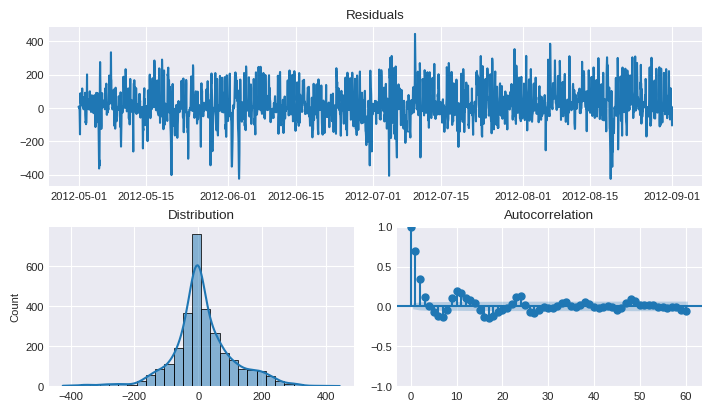

In [ ]:
# Distribución de los residuos out-sample
# ==============================================================================
residuals = datos.loc[predictions_val.index, 'users'] - predictions_val['pred']
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(
        y_true = datos.loc[predictions_val.index, 'users'],
        y_pred = predictions_val['pred'],
        figsize=(7, 4)
    )

In [ ]:
# Almacenar residuos out-sample en el forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    y_true = datos.loc[predictions_val.index, 'users'],
    y_pred = predictions_val['pred']
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



A continuación, se ejecuta el proceso de backtesting para estimar los intervalos de predicción en el conjunto de test. Se indica el argumento use_in_sample_residuals en False para que se utilicen los residuos out-sample almacenados previamente y use_binned_residuals para que el los residuos utilizados en el bootstrapping se seleccionen condicionados al rango de valores de las predicciones.

# **⚠ Warning**

La estimación de los intervalos de predicción mediante el método de *bootstraping* es computacionalmente costosa. Con el objetivo de limitar el tiempo necesario para el siguiente ejemplo, se reduce el conjunto de test.

In [ ]:
# Backtesting con intervalos de predicción en test usando out-sample residuals
# ==============================================================================
fin_test = '2012-10-31 23:00:00'
cv = TimeSeriesFold(
        steps              = 24,
        initial_train_size = len(datos.loc[:fin_validacion]),
        refit              = False,
)
metric, predictions = backtesting_forecaster(
   forecaster              = forecaster,
   y                       = datos.loc[:fin_test, 'users'],
   exog                    = datos.loc[:fin_test, exog_cols],
   cv                      = cv,
   metric                  = 'mean_absolute_error',
   interval                = [5, 95], # 90% intervalo de predicción
   n_boot                  = 150,
   use_in_sample_residuals = False,  # Usar out-sample residuals
   use_binned_residuals    = True,   # Usar residuos condicionados al valor predicho
   n_jobs                  = 'auto',
   verbose                 = False,
   show_progress           = True
)
predictions.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/61 [00:00<?, ?it/s]

pred  lower_bound  upper_bound
2012-09-01 00:00:00  134.840068    86.930119   221.941836
2012-09-01 01:00:00   90.710515    26.864475   229.438191
2012-09-01 02:00:00   56.694694    15.773340   232.294291
2012-09-01 03:00:00   16.854778     3.160760   211.777414
2012-09-01 04:00:00    7.300785     3.418589   365.074434

In [ ]:
# Plot prediction intervals vs real value
# ==============================================================================
fig = go.Figure([
    go.Scatter(name='Prediction', x=predictions.index, y=predictions['pred'], mode='lines'),
    go.Scatter(
        name='Real value', x=datos_test.loc[:fin_test].index, y=datos_test.loc[:fin_test, 'users'], mode='lines',
    ),
    go.Scatter(
        name='Upper Bound', x=predictions.index, y=predictions['upper_bound'], mode='lines',
        marker=dict(color="#444"), line=dict(width=0), showlegend=False
    ),
    go.Scatter(
        name='Lower Bound', x=predictions.index, y=predictions['lower_bound'], marker=dict(color="#444"),
        line=dict(width=0), mode='lines', fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False
    )
])
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="users",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001),
    # Initial zoom on x axis from 1 oct to 10 oct
    xaxis=dict(range=['2012-10-01', '2012-10-10'])
)
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Cobertura del intervalo en los datos de test
# ==============================================================================
coverage = np.mean(
    np.logical_and(
        datos.loc[fin_validacion:fin_test, 'users'] >= predictions["lower_bound"],
        datos.loc[fin_validacion:fin_test, 'users'] <= predictions["upper_bound"]
    )
)
area = (predictions['upper_bound'] - predictions['lower_bound']).sum()
print(f"Total area of the interval: {round(area, 2)}")
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

Total area of the interval: 547680.72
Predicted interval coverage: 95.49 %


Total area of the interval: 579968.65
Predicted interval coverage: 94.4 %
La cobertura observada de los intervalos es superior a la cobertura teórica esperada (90%), los intervalos son más conservadores de lo nesario. Esto significa que contienen el valor real con mayor probabilidad de la esperada.

## **✎ Nota**

Para información detallada de las funcionalidades de forecasting probabilístico ofrecidas por skforecast visitar: Forecasting probabilístico con machine learning.

# **Explicabilidad del modelo**

Debido a la naturaleza compleja de muchos de los actuales modelos de machine learning, a menudo funcionan como cajas negras, lo que dificulta entender por qué han hecho una predicción u otra. Las técnicas de explicabilidad pretenden desmitificar estos modelos, proporcionando información sobre su funcionamiento interno y ayudando a generar confianza, mejorar la transparencia y cumplir los requisitos normativos en diversos ámbitos. Mejorar la explicabilidad de los modelos no sólo ayuda a comprender su comportamiento, sino también a identificar sesgos, mejorar su rendimiento y permitir a las partes interesadas tomar decisiones más informadas basadas en los conocimientos del machine learning

Skforecast es compatible con algunos de los métodos de explicabilidad más populares: model-specific feature importances, SHAP values, and partial dependence plots.

In [ ]:
# Crear y entrenar el forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    regressor        = LGBMRegressor(**best_params),
    lags             = [1, 2, 3, 23, 24, 25, 167, 168, 169],
    window_features  = window_features,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)
forecaster.fit(
    y    = datos.loc[:fin_validacion, 'users'],
    exog = datos.loc[:fin_validacion, exog_cols]
)

# **Model-specific feature importance**

In [ ]:
# Extraer importancia de los predictores
# ==============================================================================
importancia = forecaster.get_feature_importances()
importancia.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



feature  importance
0          lag_1         870
7        lag_168         659
4         lag_24         546
8        lag_169         431
6        lag_167         334
3         lag_23         304
2          lag_3         288
1          lag_2         276
9   roll_mean_72         230
97          temp         219

# **⚠ Warning**

El método get_feature_importances() sólo devuelve valores si el regresor del forecaster tiene el atributo coef_ o feature_importances_, que son los estándares en scikit-learn.
# **Shap values**
Los valores SHAP (SHapley Additive exPlanations) son un método muy utilizado para explicar los modelos de machine learning, ya que ayudan a comprender cómo influyen las variables y los valores en las predicciones de forma visual y cuantitativa.

Se puede obtener un análisis SHAP a partir de modelos skforecast con sólo dos elementos:

El regresor interno del forecaster.

Las matrices de entrenamiento creadas a partir de la serie temporal y variables exógenas, utilizadas para ajustar el pronosticador.

Aprovechando estos dos componentes, los usuarios pueden crear explicaciones interpretables para sus modelos de skforecast. Estas explicaciones pueden utilizarse para verificar la fiabilidad del modelo, identificar los factores más significativos que contribuyen a las predicciones y comprender mejor la relación subyacente entre las variables de entrada y la variable objetivo.

In [ ]:
# Matrices de entrenamiento utilizadas por el forecaster para entrenar el regresor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                        y    = datos.loc[:fin_validacion, 'users'],
                        exog = datos.loc[:fin_validacion, exog_cols]
                    )
display(X_train.head(3))
display(y_train.head(3))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lag_1  lag_2  lag_3  lag_23  lag_24  lag_25  lag_167  \
date_time                                                                   
2011-01-15 01:00:00   28.0   27.0   36.0     1.0     5.0    14.0     16.0   
2011-01-15 02:00:00   20.0   28.0   27.0     1.0     1.0     5.0      7.0   
2011-01-15 03:00:00   12.0   20.0   28.0     1.0     1.0     1.0      1.0   

                     lag_168  lag_169  roll_mean_72  ... temp_window_1D_mean  \
date_time                                            ...                       
2011-01-15 01:00:00     16.0     25.0     55.736111  ...            6.594167   
2011-01-15 02:00:00     16.0     16.0     55.930556  ...            6.696667   
2011-01-15 03:00:00      7.0     16.0     56.083333  ...            6.799167   

                     temp_window_1D_max  temp_window_1D_min  \
date_time                                                     
2011-01-15 01:00:00                9.84                 4.1   
2011-01-15 02:00:00                9.84                 4.1   
2011-01-15 03:00:00                9.84                 4.1   

                     temp_window_7D_mean  temp_window_7D_max  \
date_time                                                      
2011-01-15 01:00:00             6.535595                9.84   
2011-01-15 02:00:00             6.530715                9.84   
2011-01-15 03:00:00             6.525833                9.84   

                     temp_window_7D_min  holiday_previous_day  \
date_time                                                       
2011-01-15 01:00:00                3.28                   0.0   
2011-01-15 02:00:00                3.28                   0.0   
2011-01-15 03:00:00                3.28                   0.0   

                     holiday_next_day  temp  holiday  
date_time                                             
2011-01-15 01:00:00               0.0  6.56      0.0  
2011-01-15 02:00:00               0.0  6.56      0.0  
2011-01-15 03:00:00               0.0  6.56      0.0  

[3 rows x 99 columns]

date_time
2011-01-15 01:00:00    20.0
2011-01-15 02:00:00    12.0
2011-01-15 03:00:00     8.0
Freq: h, Name: y, dtype: float32

In [ ]:
# Crear SHAP explainer (para modelos basados en árboles)
# ==============================================================================
explainer = shap.TreeExplainer(forecaster.regressor)

# Se selecciona una muestra del 50% de los datos para acelerar el cálculo
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# **✎ Note**

La librería Shap cuenta con varios *Explainers*, cada uno diseñado para un tipo de modelo diferente. El shap.TreeExplainer explainer se utiliza para modelos basados en árboles, como el LGBMRegressor utilizado en este ejemplo. Para más información, consultar la documentación de SHAP..

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



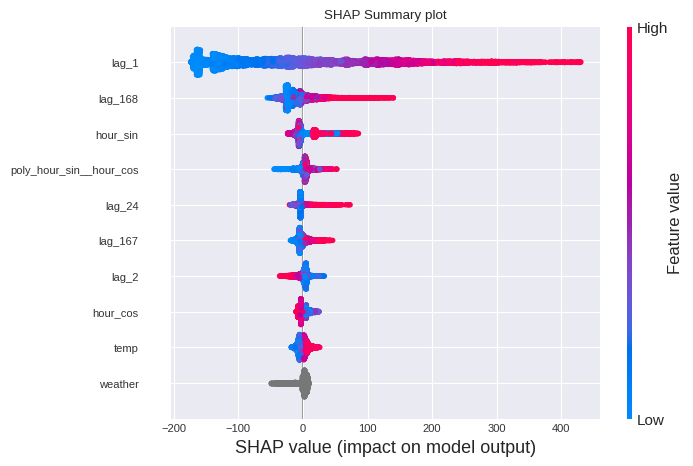

In [ ]:
# Shap summary plot (top 10)
# ==============================================================================
shap.initjs()
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(8, 4.5)

In [ ]:
pip install -q shap

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Force plot para la primera observación de la muestra
# ==============================================================================
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train_sample.iloc[0, :])

# **XGBoost, CatBoost y HistGradientBoostingRegressor**

Desde el éxito del Gradient Boosting como algoritmo de machine learning, se han desarrollado varias implementaciones. Además de LightGBM, otras tres muy populares son: XGBoost, CatBoost e HistGradientBoostingRegressor. Todas ellas son compatibles con skforecast.

**XGBoost**: desarrollado por Tianqi Chen.

**HistGradientBoostingRegressor**: desarrollado por scikit-learn.

**CatBoost**: desarrollado por Yandex.

Las siguientes secciones muestran cómo utilizar estas implementaciones para crear modelos de forecasting, haciendo hincapié en el uso de su soporte nativo para características categóricas. Esta vez se utiliza una estrategia de validación one-step-ahead para acelerar la búsqueda de hiperparámetros.


In [ ]:
# Particiones utilizadas para la búsqueda de hiperparámetros y backtesting
# ==============================================================================
cv_search = OneStepAheadFold(initial_train_size = len(datos_train))

cv_backtesting = TimeSeriesFold(
                    steps              = 36,
                    initial_train_size = len(datos[:fin_validacion]),
                    refit              = False,
                )

# **XGBoost**

In [ ]:
# Encoding ordinal + conversión a tipo category
# ==============================================================================
pipeline_categorical = make_pipeline(
        OrdinalEncoder(
            dtype=int,
            handle_unknown="use_encoded_value",
            unknown_value=-1,
            encoded_missing_value=-1
        ),
        FunctionTransformer(
            func=lambda x: x.astype('category'),
            feature_names_out= 'one-to-one'
        )
    )

transformer_exog = make_column_transformer(
    (
        pipeline_categorical,
        make_column_selector(dtype_exclude=np.number)
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [ ]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    regressor = XGBRegressor(tree_method='hist', enable_categorical=True, random_state=123),
    lags = 24,
    window_features  = window_features,
    transformer_exog = transformer_exog
)

In [ ]:
# Búsqueda de hiperparámetros
# ==============================================================================
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'subsample'       : trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster    = forecaster,
    y             = datos.loc[:fin_validacion, 'users'],
    exog          = datos.loc[:fin_validacion, exog_cols],
    cv            = cv_search,
    search_space  = search_space,
    metric        = 'mean_absolute_error',
    n_trials      = 20,
    random_state  = 123,
    return_best   = True,
    n_jobs        = 'auto',
    verbose       = False,
    show_progress = True
)

/usr/local/lib/python3.10/dist-packages/skforecast/model_selection/_search.py:715: OneStepAheadValidationWarning:

One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)



  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 900, 'max_depth': 3, 'learning_rate': 0.011349717150972789, 'subsample': 0.7489909950808206, 'colsample_bytree': 0.7634476213564084, 'gamma': 0.1488051244585744, 'reg_alpha': 0.9772037319192796, 'reg_lambda': 0.3349293310460365}
  One-step-ahead metric: 40.60869216918945


In [ ]:
# Backtesting con datos de test
# ==============================================================================
metrica_xgboost, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos['users'],
    exog       = datos[exog_cols],
    cv         = cv_backtesting,
    metric     = 'mean_absolute_error',
    n_jobs     = 'auto',
    verbose    = False
)
metrica_xgboost

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/81 [00:00<?, ?it/s]

mean_absolute_error
0            54.791254

# **HistGradientBoostingRegressor**
Al crear un forecaster utilizando HistogramGradientBoosting, los nombres de las columnas categóricas deben especificarse durante la instanciación del regresor pasándolos como una lista al argumento categorical_feature.

In [ ]:
# Codificación ordinal
# ==============================================================================
# Se utiliza un ColumnTransformer para transformar variables categóricas
# (no numéricas) utilizando codificación ordinal. Las variables numéricas
# no se modifican. Los valores missing se codifican como -1. Si se encuentra una
# nueva categoría en el conjunto de test, se codifica como -1.
categorical_features = ['weather']
transformer_exog = make_column_transformer(
    (
        OrdinalEncoder(
            dtype=int,
            handle_unknown="use_encoded_value",
            unknown_value=-1,
            encoded_missing_value=-1
        ),
        categorical_features
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    regressor = HistGradientBoostingRegressor(
                    categorical_features=categorical_features,
                    random_state=123
                ),
    lags = 24,
    window_features  = window_features,
    transformer_exog = transformer_exog
)

In [ ]:
# Busqueda de hiperparámetros
# ==============================================================================
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

def search_space(trial):
    search_space  = {
        'max_iter'          : trial.suggest_int('max_iter', 400, 1200, step=100),
        'max_depth'         : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'     : trial.suggest_float('learning_rate', 0.01, 1),
        'min_samples_leaf'  : trial.suggest_int('min_samples_leaf', 1, 20, step=1),
        'l2_regularization' : trial.suggest_float('l2_regularization', 0, 1),
        'lags'              : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster    = forecaster,
    y             = datos.loc[:fin_validacion, 'users'],
    exog          = datos.loc[:fin_validacion, exog_cols],
    cv            = cv_search,
    search_space  = search_space,
    metric        = 'mean_absolute_error',
    n_trials      = 20,
    random_state  = 123,
    return_best   = True,
    n_jobs        = 'auto',
    verbose       = False,
    show_progress = True
)

/usr/local/lib/python3.10/dist-packages/skforecast/model_selection/_search.py:715: OneStepAheadValidationWarning:

One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)



  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'max_iter': 1200, 'max_depth': 10, 'learning_rate': 0.014839147189277493, 'min_samples_leaf': 19, 'l2_regularization': 0.015325290080303589}
  One-step-ahead metric: 40.474250550287245


In [ ]:
# Backtesting con datos de test
# ==============================================================================
metrica_histgb, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos['users'],
    exog       = datos[exog_cols],
    cv         = cv_backtesting,
    metric     = 'mean_absolute_error',
    n_jobs     = 'auto',
    verbose    = False
)
metrica_histgb

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/81 [00:00<?, ?it/s]

mean_absolute_error
0            49.661191

# **CatBoost**

Desafortunadamente, la versión actual de skforecast no es compatible con el manejo nativo de varaibles categóricas de CatBoost. El problema surge porque CatBoost sólo acepta variables categóricas codificadas como enteros, mientras que skforecast convierte los datos de entrada a float para utilizar matrices numpy y así acelerar el proceso. Para evitar esta limitación, es necesario aplicar one-hot encoding o label encoding a las variables categóricas antes de utilizarlas con CatBoost.

In [ ]:
# One hot encoding
# ==============================================================================
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='if_binary'),
        make_column_selector(dtype_exclude=np.number),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Crear forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    regressor = CatBoostRegressor(
                    random_state=123,
                    silent=True,
                    allow_writing_files=False,
                    boosting_type = 'Plain',         # Faster training
                    leaf_estimation_iterations = 3,  # Faster training
                ),
    lags = 24,
    window_features = window_features,
    transformer_exog = one_hot_encoder
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Búsqueda de hiperparámetros
# ==============================================================================
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 1),
        'lags'          : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster    = forecaster,
    y             = datos.loc[:fin_validacion, 'users'],
    exog          = datos.loc[:fin_validacion, exog_cols],
    cv            = cv_search,
    search_space  = search_space,
    metric        = 'mean_absolute_error',
    n_trials      = 20,
    random_state  = 123,
    return_best   = True,
    n_jobs        = 'auto',
    verbose       = False,
    show_progress = True
)

/usr/local/lib/python3.10/dist-packages/skforecast/model_selection/_search.py:715: OneStepAheadValidationWarning:

One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)



  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.2149475007765609}
  One-step-ahead metric: 39.04101904030121


In [ ]:
# Backtesting con datos de test
# ==============================================================================
metrica_catboost, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos['users'],
    exog       = datos[exog_cols],
    cv         = cv_backtesting,
    metric     = 'mean_absolute_error',
    n_jobs     = 'auto',
    verbose    = False
)
metrica_catboost

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/81 [00:00<?, ?it/s]

mean_absolute_error
0            54.462643

# **Conclusión**
Utilizar modelos Gradient Boosting en problemas de forecasting es muy sencillo gracias a las funcionalidades ofrecidas por skforecast.

Como se ha mostrado en este documento, la incorporación de variables exógenas como predictores puede mejorar en gran medida la capacidad predictiva del modelo.

Las variables categóricas pueden incluirse facilmente como variables exógenas sin necesidad de preprocesamiento. Esto es posible gracias al soporte nativo para variables categóricas ofrecido por LightGBM, XGBoost y HistGradientBoostingRegressor.

In [ ]:
# metricas = pd.concat(
#     [metrica_baseline, metrica_lgbm, metrica_xgboost, metrica_histgb, metrica_catboost],
#     axis=0,
# )
# metricas.index = [
#     "Baseline",
#     "LGBMRegressor",
#     "XGBRegressor",
#     "HistGradientBoostingRegressor",
#     "CatBoostRegressor",
# ]
# metricas.round(2).sort_values(by="mean_absolute_error")


## **🖉 Nota**
Para ilustrar el proceso, la búsqueda de hiperparámetros se ha mantenido reducida. Sin embargo, para obtener resultados óptimos, puede ser necesario realizar una búsqueda más amplia para cada modelo.
# **Información de sesión**

In [ ]:
import session_info
session_info.show(html=False)

-----
astral              3.2
catboost            1.2.7
feature_engine      1.8.2
lightgbm            4.5.0
matplotlib          3.8.0
numpy               1.26.4
optuna              4.1.0
pandas              2.2.2
plotly              5.24.1
session_info        1.0.0
shap                0.46.0
skforecast          0.14.0
sklearn             1.5.2
statsmodels         0.14.4
xgboost             2.1.3
-----
IPython             7.34.0
jupyter_client      6.1.12
jupyter_core        5.7.2
notebook            6.5.5
-----
Python 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
Linux-6.1.85+-x86_64-with-glibc2.35
-----
Session information updated at 2024-12-15 16:09


<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()



# **Bibliografía**
Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia.

Time Series Analysis and Forecasting with ADAM Ivan Svetunkov.

Joseph, M. (2022). Modern time series forecasting with Python: Explore industry-ready time series forecasting using modern machine learning and Deep Learning. Packt Publishing.